##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate Portuguese to English. This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
!pip install -q tfds-nightly

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipeline

Use [TFDS](https://www.tensorflow.org/datasets) to load the [Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDDYXSP/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDDYXSP/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDDYXSP/ted_hrlr_translate-test.tfrecord
Dataset ted_hrlr_translate downloaded and prepared to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


Create a custom subwords tokenizer from the training dataset. 

In [5]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [6]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [7]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [9]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [10]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

Note: To keep this example small and relatively fast, drop examples with a length of over 40 tokens.

In [11]:
MAX_LENGTH = 40

In [12]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [14]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [15]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [16]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


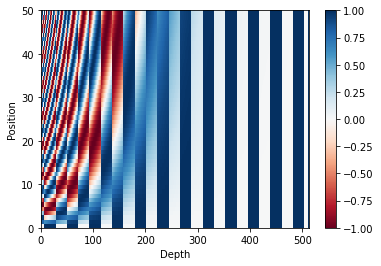

In [17]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [18]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [19]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [20]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [21]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [23]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [24]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [25]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [26]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [27]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [29]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [30]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [31]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [33]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [35]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [36]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [37]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [38]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [39]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [40]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [41]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [42]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [44]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

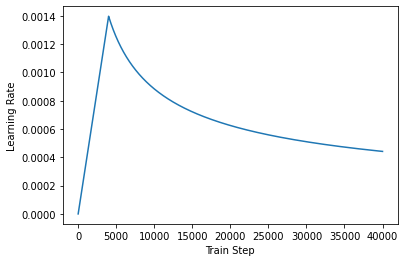

In [45]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [47]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [48]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [49]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [50]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [51]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [52]:
EPOCHS = 20

In [53]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

Portuguese is used as the input language and English is the target language.

In [54]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0005 Accuracy 0.0000


Epoch 1 Batch 50 Loss 8.9530 Accuracy 0.0007


Epoch 1 Batch 100 Loss 8.8622 Accuracy 0.0115


Epoch 1 Batch 150 Loss 8.7592 Accuracy 0.0167


Epoch 1 Batch 200 Loss 8.6354 Accuracy 0.0193


Epoch 1 Batch 250 Loss 8.4868 Accuracy 0.0216


Epoch 1 Batch 300 Loss 8.3156 Accuracy 0.0240


Epoch 1 Batch 350 Loss 8.1325 Accuracy 0.0283


Epoch 1 Batch 400 Loss 7.9531 Accuracy 0.0318


Epoch 1 Batch 450 Loss 7.7899 Accuracy 0.0348


Epoch 1 Batch 500 Loss 7.6434 Accuracy 0.0380


Epoch 1 Batch 550 Loss 7.5091 Accuracy 0.0415


Epoch 1 Batch 600 Loss 7.3815 Accuracy 0.0452


Epoch 1 Batch 650 Loss 7.2589 Accuracy 0.0487


Epoch 1 Batch 700 Loss 7.1422 Accuracy 0.0522
Epoch 1 Loss 7.1379 Accuracy 0.0523
Time taken for 1 epoch: 55.227755069732666 secs

Epoch 2 Batch 0 Loss 5.5778 Accuracy 0.0921


Epoch 2 Batch 50 Loss 5.4727 Accuracy 0.1035


Epoch 2 Batch 100 Loss 5.4241 Accuracy 0.1061


Epoch 2 Batch 150 Loss 5.3629 Accuracy 0.1087


Epoch 2 Batch 200 Loss 5.3115 Accuracy 0.1104


Epoch 2 Batch 250 Loss 5.2689 Accuracy 0.1126


Epoch 2 Batch 300 Loss 5.2314 Accuracy 0.1142


Epoch 2 Batch 350 Loss 5.1934 Accuracy 0.1159


Epoch 2 Batch 400 Loss 5.1581 Accuracy 0.1177


Epoch 2 Batch 450 Loss 5.1253 Accuracy 0.1192


Epoch 2 Batch 500 Loss 5.0975 Accuracy 0.1204


Epoch 2 Batch 550 Loss 5.0690 Accuracy 0.1218


Epoch 2 Batch 600 Loss 5.0440 Accuracy 0.1229


Epoch 2 Batch 650 Loss 5.0206 Accuracy 0.1243


Epoch 2 Batch 700 Loss 4.9982 Accuracy 0.1253
Epoch 2 Loss 4.9975 Accuracy 0.1254
Time taken for 1 epoch: 29.222673654556274 secs

Epoch 3 Batch 0 Loss 4.7296 Accuracy 0.1233


Epoch 3 Batch 50 Loss 4.5995 Accuracy 0.1418


Epoch 3 Batch 100 Loss 4.5976 Accuracy 0.1424


Epoch 3 Batch 150 Loss 4.5859 Accuracy 0.1431


Epoch 3 Batch 200 Loss 4.5728 Accuracy 0.1437


Epoch 3 Batch 250 Loss 4.5634 Accuracy 0.1444


Epoch 3 Batch 300 Loss 4.5507 Accuracy 0.1450


Epoch 3 Batch 350 Loss 4.5348 Accuracy 0.1464


Epoch 3 Batch 400 Loss 4.5219 Accuracy 0.1471


Epoch 3 Batch 450 Loss 4.5066 Accuracy 0.1480


Epoch 3 Batch 500 Loss 4.4918 Accuracy 0.1488


Epoch 3 Batch 550 Loss 4.4763 Accuracy 0.1497


Epoch 3 Batch 600 Loss 4.4627 Accuracy 0.1507


Epoch 3 Batch 650 Loss 4.4462 Accuracy 0.1517


Epoch 3 Batch 700 Loss 4.4327 Accuracy 0.1525
Epoch 3 Loss 4.4321 Accuracy 0.1525
Time taken for 1 epoch: 29.389445304870605 secs

Epoch 4 Batch 0 Loss 4.3032 Accuracy 0.1653


Epoch 4 Batch 50 Loss 4.0700 Accuracy 0.1695


Epoch 4 Batch 100 Loss 4.0660 Accuracy 0.1691


Epoch 4 Batch 150 Loss 4.0641 Accuracy 0.1704


Epoch 4 Batch 200 Loss 4.0517 Accuracy 0.1713


Epoch 4 Batch 250 Loss 4.0392 Accuracy 0.1725


Epoch 4 Batch 300 Loss 4.0218 Accuracy 0.1738


Epoch 4 Batch 350 Loss 4.0098 Accuracy 0.1747


Epoch 4 Batch 400 Loss 3.9930 Accuracy 0.1758


Epoch 4 Batch 450 Loss 3.9805 Accuracy 0.1766


Epoch 4 Batch 500 Loss 3.9684 Accuracy 0.1779


Epoch 4 Batch 550 Loss 3.9550 Accuracy 0.1788


Epoch 4 Batch 600 Loss 3.9410 Accuracy 0.1796


Epoch 4 Batch 650 Loss 3.9266 Accuracy 0.1806


Epoch 4 Batch 700 Loss 3.9129 Accuracy 0.1815
Epoch 4 Loss 3.9129 Accuracy 0.1815
Time taken for 1 epoch: 29.373191595077515 secs

Epoch 5 Batch 0 Loss 3.6592 Accuracy 0.2146


Epoch 5 Batch 50 Loss 3.5730 Accuracy 0.1983


Epoch 5 Batch 100 Loss 3.5666 Accuracy 0.2006


Epoch 5 Batch 150 Loss 3.5539 Accuracy 0.2003


Epoch 5 Batch 200 Loss 3.5464 Accuracy 0.2005


Epoch 5 Batch 250 Loss 3.5414 Accuracy 0.2011


Epoch 5 Batch 300 Loss 3.5311 Accuracy 0.2019


Epoch 5 Batch 350 Loss 3.5189 Accuracy 0.2023


Epoch 5 Batch 400 Loss 3.5088 Accuracy 0.2033


Epoch 5 Batch 450 Loss 3.4989 Accuracy 0.2044


Epoch 5 Batch 500 Loss 3.4944 Accuracy 0.2050


Epoch 5 Batch 550 Loss 3.4835 Accuracy 0.2058


Epoch 5 Batch 600 Loss 3.4762 Accuracy 0.2063


Epoch 5 Batch 650 Loss 3.4692 Accuracy 0.2069


Epoch 5 Batch 700 Loss 3.4570 Accuracy 0.2076


Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 3.4570 Accuracy 0.2076
Time taken for 1 epoch: 29.62894082069397 secs

Epoch 6 Batch 0 Loss 3.0676 Accuracy 0.2079


Epoch 6 Batch 50 Loss 3.1464 Accuracy 0.2222


Epoch 6 Batch 100 Loss 3.1415 Accuracy 0.2224


Epoch 6 Batch 150 Loss 3.1251 Accuracy 0.2233


Epoch 6 Batch 200 Loss 3.1303 Accuracy 0.2233


Epoch 6 Batch 250 Loss 3.1271 Accuracy 0.2240


Epoch 6 Batch 300 Loss 3.1222 Accuracy 0.2243


Epoch 6 Batch 350 Loss 3.1155 Accuracy 0.2245


Epoch 6 Batch 400 Loss 3.1114 Accuracy 0.2252


Epoch 6 Batch 450 Loss 3.1075 Accuracy 0.2251


Epoch 6 Batch 500 Loss 3.1011 Accuracy 0.2256


Epoch 6 Batch 550 Loss 3.0944 Accuracy 0.2256


Epoch 6 Batch 600 Loss 3.0865 Accuracy 0.2259


Epoch 6 Batch 650 Loss 3.0789 Accuracy 0.2264


Epoch 6 Batch 700 Loss 3.0734 Accuracy 0.2272
Epoch 6 Loss 3.0726 Accuracy 0.2272
Time taken for 1 epoch: 29.619795560836792 secs

Epoch 7 Batch 0 Loss 2.6502 Accuracy 0.2699


Epoch 7 Batch 50 Loss 2.7479 Accuracy 0.2450


Epoch 7 Batch 100 Loss 2.7388 Accuracy 0.2455


Epoch 7 Batch 150 Loss 2.7329 Accuracy 0.2451


Epoch 7 Batch 200 Loss 2.7345 Accuracy 0.2455


Epoch 7 Batch 250 Loss 2.7379 Accuracy 0.2450


Epoch 7 Batch 300 Loss 2.7314 Accuracy 0.2457


Epoch 7 Batch 350 Loss 2.7256 Accuracy 0.2456


Epoch 7 Batch 400 Loss 2.7182 Accuracy 0.2467


Epoch 7 Batch 450 Loss 2.7106 Accuracy 0.2470


Epoch 7 Batch 500 Loss 2.7048 Accuracy 0.2477


Epoch 7 Batch 550 Loss 2.7012 Accuracy 0.2481


Epoch 7 Batch 600 Loss 2.6969 Accuracy 0.2483


Epoch 7 Batch 650 Loss 2.6922 Accuracy 0.2488


Epoch 7 Batch 700 Loss 2.6878 Accuracy 0.2494
Epoch 7 Loss 2.6879 Accuracy 0.2494
Time taken for 1 epoch: 29.344128608703613 secs

Epoch 8 Batch 0 Loss 2.0878 Accuracy 0.2922


Epoch 8 Batch 50 Loss 2.3954 Accuracy 0.2664


Epoch 8 Batch 100 Loss 2.3886 Accuracy 0.2660


Epoch 8 Batch 150 Loss 2.3882 Accuracy 0.2647


Epoch 8 Batch 200 Loss 2.3828 Accuracy 0.2647


Epoch 8 Batch 250 Loss 2.3849 Accuracy 0.2643


Epoch 8 Batch 300 Loss 2.3867 Accuracy 0.2639


Epoch 8 Batch 350 Loss 2.3880 Accuracy 0.2644


Epoch 8 Batch 400 Loss 2.3824 Accuracy 0.2650


Epoch 8 Batch 450 Loss 2.3813 Accuracy 0.2644


Epoch 8 Batch 500 Loss 2.3770 Accuracy 0.2649


Epoch 8 Batch 550 Loss 2.3748 Accuracy 0.2654


Epoch 8 Batch 600 Loss 2.3735 Accuracy 0.2656


Epoch 8 Batch 650 Loss 2.3718 Accuracy 0.2657


Epoch 8 Batch 700 Loss 2.3706 Accuracy 0.2661
Epoch 8 Loss 2.3704 Accuracy 0.2661
Time taken for 1 epoch: 29.539512157440186 secs

Epoch 9 Batch 0 Loss 2.3050 Accuracy 0.2683


Epoch 9 Batch 50 Loss 2.1005 Accuracy 0.2827


Epoch 9 Batch 100 Loss 2.1171 Accuracy 0.2826


Epoch 9 Batch 150 Loss 2.1191 Accuracy 0.2819


Epoch 9 Batch 200 Loss 2.1282 Accuracy 0.2807


Epoch 9 Batch 250 Loss 2.1299 Accuracy 0.2799


Epoch 9 Batch 300 Loss 2.1313 Accuracy 0.2804


Epoch 9 Batch 350 Loss 2.1334 Accuracy 0.2800


Epoch 9 Batch 400 Loss 2.1306 Accuracy 0.2803


Epoch 9 Batch 450 Loss 2.1340 Accuracy 0.2806


Epoch 9 Batch 500 Loss 2.1366 Accuracy 0.2805


Epoch 9 Batch 550 Loss 2.1365 Accuracy 0.2802


Epoch 9 Batch 600 Loss 2.1366 Accuracy 0.2802


Epoch 9 Batch 650 Loss 2.1381 Accuracy 0.2800


Epoch 9 Batch 700 Loss 2.1414 Accuracy 0.2801
Epoch 9 Loss 2.1417 Accuracy 0.2801
Time taken for 1 epoch: 29.506006717681885 secs

Epoch 10 Batch 0 Loss 1.7658 Accuracy 0.3218


Epoch 10 Batch 50 Loss 1.9077 Accuracy 0.2935


Epoch 10 Batch 100 Loss 1.9111 Accuracy 0.2916


Epoch 10 Batch 150 Loss 1.9228 Accuracy 0.2912


Epoch 10 Batch 200 Loss 1.9319 Accuracy 0.2899


Epoch 10 Batch 250 Loss 1.9373 Accuracy 0.2894


Epoch 10 Batch 300 Loss 1.9431 Accuracy 0.2894


Epoch 10 Batch 350 Loss 1.9470 Accuracy 0.2897


Epoch 10 Batch 400 Loss 1.9526 Accuracy 0.2898


Epoch 10 Batch 450 Loss 1.9540 Accuracy 0.2904


Epoch 10 Batch 500 Loss 1.9562 Accuracy 0.2904


Epoch 10 Batch 550 Loss 1.9577 Accuracy 0.2905


Epoch 10 Batch 600 Loss 1.9618 Accuracy 0.2907


Epoch 10 Batch 650 Loss 1.9647 Accuracy 0.2907


Epoch 10 Batch 700 Loss 1.9671 Accuracy 0.2905


Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Loss 1.9671 Accuracy 0.2906
Time taken for 1 epoch: 30.555190324783325 secs

Epoch 11 Batch 0 Loss 1.8220 Accuracy 0.2686


Epoch 11 Batch 50 Loss 1.7587 Accuracy 0.3028


Epoch 11 Batch 100 Loss 1.7730 Accuracy 0.3025


Epoch 11 Batch 150 Loss 1.7838 Accuracy 0.3021


Epoch 11 Batch 200 Loss 1.7953 Accuracy 0.3013


Epoch 11 Batch 250 Loss 1.7928 Accuracy 0.3009


Epoch 11 Batch 300 Loss 1.7985 Accuracy 0.2998


Epoch 11 Batch 350 Loss 1.8009 Accuracy 0.2997


Epoch 11 Batch 400 Loss 1.8098 Accuracy 0.2989


Epoch 11 Batch 450 Loss 1.8142 Accuracy 0.2989


Epoch 11 Batch 500 Loss 1.8169 Accuracy 0.2988


Epoch 11 Batch 550 Loss 1.8204 Accuracy 0.2987


Epoch 11 Batch 600 Loss 1.8239 Accuracy 0.2988


Epoch 11 Batch 650 Loss 1.8265 Accuracy 0.2989


Epoch 11 Batch 700 Loss 1.8288 Accuracy 0.2986
Epoch 11 Loss 1.8295 Accuracy 0.2986
Time taken for 1 epoch: 29.374881982803345 secs

Epoch 12 Batch 0 Loss 1.5971 Accuracy 0.3350


Epoch 12 Batch 50 Loss 1.6420 Accuracy 0.3110


Epoch 12 Batch 100 Loss 1.6574 Accuracy 0.3081


Epoch 12 Batch 150 Loss 1.6558 Accuracy 0.3081


Epoch 12 Batch 200 Loss 1.6598 Accuracy 0.3072


Epoch 12 Batch 250 Loss 1.6686 Accuracy 0.3080


Epoch 12 Batch 300 Loss 1.6677 Accuracy 0.3088


Epoch 12 Batch 350 Loss 1.6746 Accuracy 0.3083


Epoch 12 Batch 400 Loss 1.6796 Accuracy 0.3079


Epoch 12 Batch 450 Loss 1.6871 Accuracy 0.3072


Epoch 12 Batch 500 Loss 1.6933 Accuracy 0.3067


Epoch 12 Batch 550 Loss 1.6976 Accuracy 0.3065


Epoch 12 Batch 600 Loss 1.7026 Accuracy 0.3063


Epoch 12 Batch 650 Loss 1.7077 Accuracy 0.3066


Epoch 12 Batch 700 Loss 1.7117 Accuracy 0.3065
Epoch 12 Loss 1.7118 Accuracy 0.3065
Time taken for 1 epoch: 29.305912971496582 secs

Epoch 13 Batch 0 Loss 1.6015 Accuracy 0.3080


Epoch 13 Batch 50 Loss 1.5318 Accuracy 0.3176


Epoch 13 Batch 100 Loss 1.5372 Accuracy 0.3193


Epoch 13 Batch 150 Loss 1.5449 Accuracy 0.3186


Epoch 13 Batch 200 Loss 1.5585 Accuracy 0.3175


Epoch 13 Batch 250 Loss 1.5678 Accuracy 0.3173


Epoch 13 Batch 300 Loss 1.5719 Accuracy 0.3165


Epoch 13 Batch 350 Loss 1.5787 Accuracy 0.3162


Epoch 13 Batch 400 Loss 1.5831 Accuracy 0.3153


Epoch 13 Batch 450 Loss 1.5898 Accuracy 0.3153


Epoch 13 Batch 500 Loss 1.5935 Accuracy 0.3144


Epoch 13 Batch 550 Loss 1.5990 Accuracy 0.3145


Epoch 13 Batch 600 Loss 1.6024 Accuracy 0.3138


Epoch 13 Batch 650 Loss 1.6086 Accuracy 0.3134


Epoch 13 Batch 700 Loss 1.6109 Accuracy 0.3133
Epoch 13 Loss 1.6110 Accuracy 0.3133
Time taken for 1 epoch: 29.24092197418213 secs

Epoch 14 Batch 0 Loss 1.3890 Accuracy 0.2952


Epoch 14 Batch 50 Loss 1.4290 Accuracy 0.3250


Epoch 14 Batch 100 Loss 1.4379 Accuracy 0.3220


Epoch 14 Batch 150 Loss 1.4559 Accuracy 0.3212


Epoch 14 Batch 200 Loss 1.4676 Accuracy 0.3202


Epoch 14 Batch 250 Loss 1.4760 Accuracy 0.3207


Epoch 14 Batch 300 Loss 1.4885 Accuracy 0.3205


Epoch 14 Batch 350 Loss 1.4909 Accuracy 0.3211


Epoch 14 Batch 400 Loss 1.4946 Accuracy 0.3208


Epoch 14 Batch 450 Loss 1.5006 Accuracy 0.3207


Epoch 14 Batch 500 Loss 1.5077 Accuracy 0.3201


Epoch 14 Batch 550 Loss 1.5108 Accuracy 0.3199


Epoch 14 Batch 600 Loss 1.5153 Accuracy 0.3195


Epoch 14 Batch 650 Loss 1.5197 Accuracy 0.3195


Epoch 14 Batch 700 Loss 1.5246 Accuracy 0.3190
Epoch 14 Loss 1.5245 Accuracy 0.3190
Time taken for 1 epoch: 29.347501516342163 secs

Epoch 15 Batch 0 Loss 1.4946 Accuracy 0.3085


Epoch 15 Batch 50 Loss 1.3737 Accuracy 0.3301


Epoch 15 Batch 100 Loss 1.3672 Accuracy 0.3284


Epoch 15 Batch 150 Loss 1.3800 Accuracy 0.3283


Epoch 15 Batch 200 Loss 1.3942 Accuracy 0.3271


Epoch 15 Batch 250 Loss 1.3988 Accuracy 0.3272


Epoch 15 Batch 300 Loss 1.4014 Accuracy 0.3269


Epoch 15 Batch 350 Loss 1.4094 Accuracy 0.3262


Epoch 15 Batch 400 Loss 1.4166 Accuracy 0.3257


Epoch 15 Batch 450 Loss 1.4220 Accuracy 0.3255


Epoch 15 Batch 500 Loss 1.4285 Accuracy 0.3256


Epoch 15 Batch 550 Loss 1.4322 Accuracy 0.3253


Epoch 15 Batch 600 Loss 1.4377 Accuracy 0.3249


Epoch 15 Batch 650 Loss 1.4446 Accuracy 0.3244


Epoch 15 Batch 700 Loss 1.4488 Accuracy 0.3238


Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Epoch 15 Loss 1.4488 Accuracy 0.3239
Time taken for 1 epoch: 29.638850927352905 secs

Epoch 16 Batch 0 Loss 1.1991 Accuracy 0.3530


Epoch 16 Batch 50 Loss 1.2971 Accuracy 0.3314


Epoch 16 Batch 100 Loss 1.3096 Accuracy 0.3355


Epoch 16 Batch 150 Loss 1.3160 Accuracy 0.3330


Epoch 16 Batch 200 Loss 1.3200 Accuracy 0.3330


Epoch 16 Batch 250 Loss 1.3260 Accuracy 0.3330


Epoch 16 Batch 300 Loss 1.3348 Accuracy 0.3321


Epoch 16 Batch 350 Loss 1.3402 Accuracy 0.3320


Epoch 16 Batch 400 Loss 1.3455 Accuracy 0.3312


Epoch 16 Batch 450 Loss 1.3533 Accuracy 0.3306


Epoch 16 Batch 500 Loss 1.3593 Accuracy 0.3302


Epoch 16 Batch 550 Loss 1.3660 Accuracy 0.3297


Epoch 16 Batch 600 Loss 1.3730 Accuracy 0.3296


Epoch 16 Batch 650 Loss 1.3783 Accuracy 0.3289


Epoch 16 Batch 700 Loss 1.3819 Accuracy 0.3285
Epoch 16 Loss 1.3820 Accuracy 0.3285
Time taken for 1 epoch: 29.525911331176758 secs

Epoch 17 Batch 0 Loss 1.3080 Accuracy 0.3113


Epoch 17 Batch 50 Loss 1.2531 Accuracy 0.3417


Epoch 17 Batch 100 Loss 1.2428 Accuracy 0.3396


Epoch 17 Batch 150 Loss 1.2567 Accuracy 0.3377


Epoch 17 Batch 200 Loss 1.2654 Accuracy 0.3366


Epoch 17 Batch 250 Loss 1.2703 Accuracy 0.3362


Epoch 17 Batch 300 Loss 1.2797 Accuracy 0.3349


Epoch 17 Batch 350 Loss 1.2865 Accuracy 0.3339


Epoch 17 Batch 400 Loss 1.2911 Accuracy 0.3340


Epoch 17 Batch 450 Loss 1.2950 Accuracy 0.3343


Epoch 17 Batch 500 Loss 1.3002 Accuracy 0.3339


Epoch 17 Batch 550 Loss 1.3051 Accuracy 0.3337


Epoch 17 Batch 600 Loss 1.3113 Accuracy 0.3334


Epoch 17 Batch 650 Loss 1.3173 Accuracy 0.3331


Epoch 17 Batch 700 Loss 1.3208 Accuracy 0.3332
Epoch 17 Loss 1.3207 Accuracy 0.3332
Time taken for 1 epoch: 29.23569130897522 secs

Epoch 18 Batch 0 Loss 1.0522 Accuracy 0.3385


Epoch 18 Batch 50 Loss 1.1916 Accuracy 0.3437


Epoch 18 Batch 100 Loss 1.1853 Accuracy 0.3432


Epoch 18 Batch 150 Loss 1.1994 Accuracy 0.3435


Epoch 18 Batch 200 Loss 1.2120 Accuracy 0.3424


Epoch 18 Batch 250 Loss 1.2183 Accuracy 0.3406


Epoch 18 Batch 300 Loss 1.2244 Accuracy 0.3403


Epoch 18 Batch 350 Loss 1.2316 Accuracy 0.3405


Epoch 18 Batch 400 Loss 1.2376 Accuracy 0.3396


Epoch 18 Batch 450 Loss 1.2428 Accuracy 0.3395


Epoch 18 Batch 500 Loss 1.2479 Accuracy 0.3394


Epoch 18 Batch 550 Loss 1.2537 Accuracy 0.3390


Epoch 18 Batch 600 Loss 1.2605 Accuracy 0.3380


Epoch 18 Batch 650 Loss 1.2669 Accuracy 0.3376


Epoch 18 Batch 700 Loss 1.2721 Accuracy 0.3369
Epoch 18 Loss 1.2723 Accuracy 0.3368
Time taken for 1 epoch: 29.23801350593567 secs

Epoch 19 Batch 0 Loss 1.0786 Accuracy 0.3205


Epoch 19 Batch 50 Loss 1.1217 Accuracy 0.3470


Epoch 19 Batch 100 Loss 1.1432 Accuracy 0.3462


Epoch 19 Batch 150 Loss 1.1478 Accuracy 0.3463


Epoch 19 Batch 200 Loss 1.1571 Accuracy 0.3463


Epoch 19 Batch 250 Loss 1.1640 Accuracy 0.3453


Epoch 19 Batch 300 Loss 1.1716 Accuracy 0.3451


Epoch 19 Batch 350 Loss 1.1778 Accuracy 0.3445


Epoch 19 Batch 400 Loss 1.1814 Accuracy 0.3428


Epoch 19 Batch 450 Loss 1.1885 Accuracy 0.3431


Epoch 19 Batch 500 Loss 1.1956 Accuracy 0.3424


Epoch 19 Batch 550 Loss 1.2013 Accuracy 0.3424


Epoch 19 Batch 600 Loss 1.2084 Accuracy 0.3419


Epoch 19 Batch 650 Loss 1.2147 Accuracy 0.3413


Epoch 19 Batch 700 Loss 1.2212 Accuracy 0.3407
Epoch 19 Loss 1.2213 Accuracy 0.3407
Time taken for 1 epoch: 29.36856746673584 secs

Epoch 20 Batch 0 Loss 1.1117 Accuracy 0.3153


Epoch 20 Batch 50 Loss 1.0757 Accuracy 0.3482


Epoch 20 Batch 100 Loss 1.0988 Accuracy 0.3480


Epoch 20 Batch 150 Loss 1.1089 Accuracy 0.3480


Epoch 20 Batch 200 Loss 1.1157 Accuracy 0.3472


Epoch 20 Batch 250 Loss 1.1256 Accuracy 0.3463


Epoch 20 Batch 300 Loss 1.1314 Accuracy 0.3468


Epoch 20 Batch 350 Loss 1.1376 Accuracy 0.3456


Epoch 20 Batch 400 Loss 1.1419 Accuracy 0.3456


Epoch 20 Batch 450 Loss 1.1479 Accuracy 0.3451


Epoch 20 Batch 500 Loss 1.1528 Accuracy 0.3453


Epoch 20 Batch 550 Loss 1.1580 Accuracy 0.3447


Epoch 20 Batch 600 Loss 1.1657 Accuracy 0.3447


Epoch 20 Batch 650 Loss 1.1710 Accuracy 0.3442


Epoch 20 Batch 700 Loss 1.1765 Accuracy 0.3440


Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Epoch 20 Loss 1.1769 Accuracy 0.3440
Time taken for 1 epoch: 29.240405321121216 secs



## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [55]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [56]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [57]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [58]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem we have to contain ....
Real translation: this is a problem we have to solve .


In [59]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [60]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm very quickly to share with you some magic stories that had happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did have .


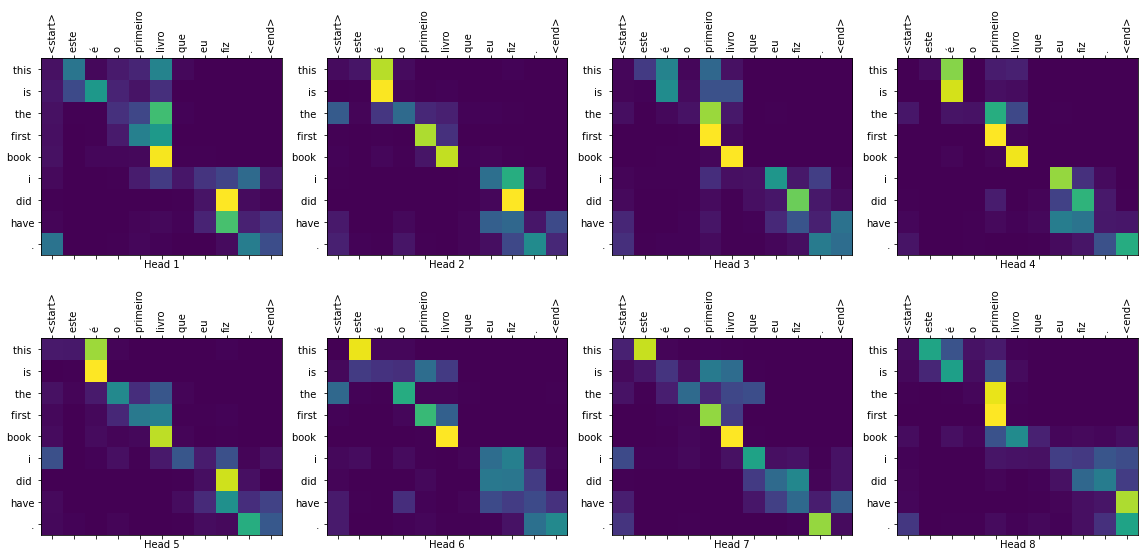

Real translation: this is the first book i've ever done.


In [61]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.